In [14]:
import numpy as np
import pandas as pd
from radioReduction import *
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.optimize as op
import random
import emcee
import corner


In [15]:
'''
Importing the data and binning every 10 seconds
'''
dt = pd.read_table('1314/2M1314e18-LLRR.dat')
binned = binning(dt,sec=10,binning=2)

def binPlot(Type='minutes'):
    if Type == 'minutes':
        plt.errorbar(binned['dtmin'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['dtmin'],binned['re'],color='black',label='Data')
    else:
        plt.errorbar(binned['secs'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['secs'],binned['re'],color='black',label='Data') 

In [23]:
'''
Defining our model, likelihoood, and prior functions
'''
def linearModel(theta,x):
    '''
    Linear model fitting to the data
    '''
    m,b = theta
    y = m*x+b
    return y

def lnprior(theta):
    '''
    Uniform priors for m and b constrained by the data
    '''
    m,b = theta
    if -1 < m < .5 and 1.0 < b < 1.5:
        return 0.0
    return -np.inf

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-linearModel(theta,x))**2/yerr**2))

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [24]:
# Putting data to variables
x = binned['dtmin']
y = binned['re']
yerr = binned['ure']

In [25]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
nll = lambda *args: -lnlike(*args)
x0 = [5,3]
linearResult = op.minimize(nll,x0,args=(x,y,yerr))
m_ml,b_ml = linearResult.x
print(m_ml,b_ml)


-0.011736489004557886 1.1799713404764813


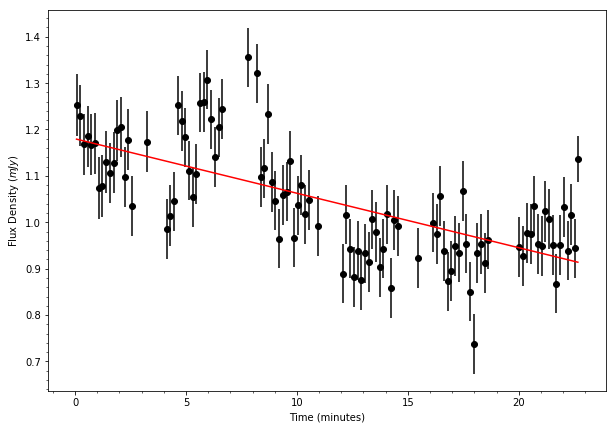

In [26]:
# Plotting results from maximized likelihood
plt.figure(figsize=(10,7))
binPlot(Type='minutes')
plt.plot(x,linearModel([m_ml,b_ml],x),color='red',label='Linear Model')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e18_linearModel.png')
plt.show()

In [34]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 2,100

# Initial position somewhere close to the maximum likelihood result
p0 = [linearResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
linearSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = linearSampler.run_mcmc(p0,500)

# Running MCMC
linearSampler.run_mcmc(pos,5000)

(array([[-0.0126448 ,  1.18376448],
        [-0.01246526,  1.18065257],
        [-0.01263705,  1.18869336],
        [-0.01170391,  1.17624719],
        [-0.01165641,  1.17723344],
        [-0.0119032 ,  1.17376443],
        [-0.01189904,  1.19036318],
        [-0.010917  ,  1.18572926],
        [-0.00968104,  1.15406874],
        [-0.0113861 ,  1.17006268],
        [-0.01198379,  1.19648791],
        [-0.01129435,  1.18721557],
        [-0.01239003,  1.20152099],
        [-0.01166779,  1.17890322],
        [-0.01153167,  1.17672492],
        [-0.01127043,  1.166858  ],
        [-0.01119981,  1.17092337],
        [-0.01287716,  1.20015322],
        [-0.01183807,  1.18012895],
        [-0.01266663,  1.19886267],
        [-0.01202144,  1.19537847],
        [-0.01187352,  1.18038706],
        [-0.01042977,  1.17112473],
        [-0.01122661,  1.17358021],
        [-0.01003617,  1.15967797],
        [-0.01251507,  1.18707732],
        [-0.01226891,  1.18893302],
        [-0.01180923,  1.163

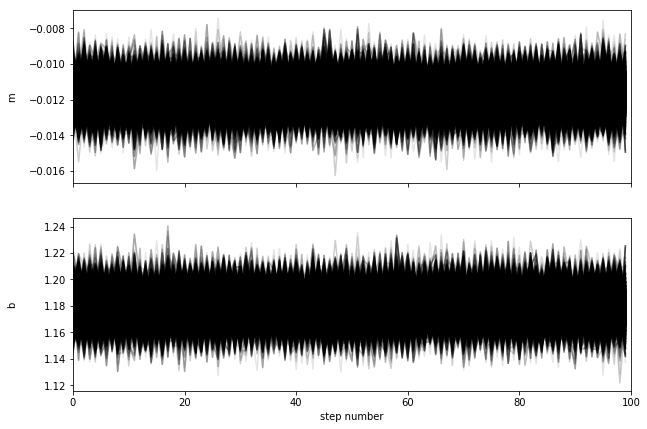

In [35]:
# Plotting the chains
fig, axes = plt.subplots(2,figsize=(10,7),sharex=True)
linearSamples = linearSampler.chain
labels = ['m','b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(linearSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(linearSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e18_linearTrace.png')
plt.show()

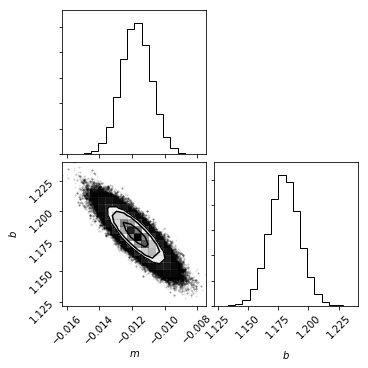

In [36]:
# Flattening the sampler
linearFlat = linearSampler.chain[:,:,:].reshape((-1,ndim))

fig = corner.corner(linearFlat,labels=['$m$','$b$'])
plt.savefig('plots/1314e18_linearCorner.png')
plt.show()

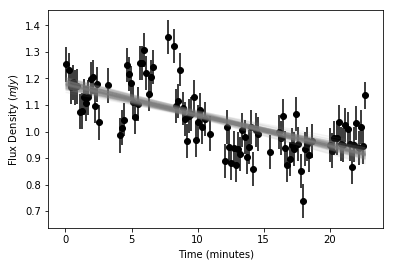

In [30]:
# Plotting first few MCMC steps on the data
binPlot(Type='minutes')
for m,b in linearFlat[np.random.randint(len(linearFlat),size=100)]:
    plt.plot(binned['dtmin'],m*binned['dtmin']+b,color='gray',alpha=0.1)
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314e18_500mcmc_data.png')
plt.show()

In [31]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(linearFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

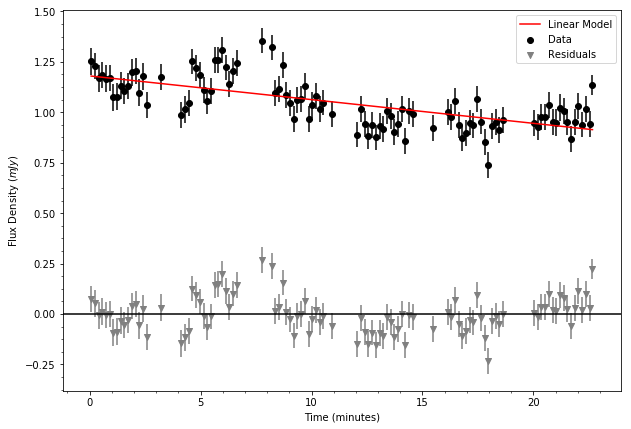

In [37]:
# Getting the 50th percentile of each parameter
linearParameters = []

for i in range(ndim):
    linearParameters.append(np.percentile(linearFlat[:,i],50))
linearParameters = np.array(linearParameters)

# Making model line
linear_model = linearModel(linearParameters,x)

# Residuals
linear_resid = y - linear_model

# Plotting the 50th percentile against the data along with residuals
plt.figure(figsize=(10,7))
plt.scatter(x,y,color='k',marker='o',label='Data')
plt.errorbar(x,y,yerr=yerr,color='black',linestyle='None',label='_nolegend_')
plt.plot(x,linear_model,color='red',label='Linear Model')
plt.scatter(x,linear_resid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,linear_resid,yerr=yerr,color='gray',linestyle='None',label='_nolegend_')
plt.axhline(y=0,color='black')
plt.legend(loc='best')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e18_linearModel_fit.png')
plt.show()

In [11]:
rr = pd.read_table('1314/2M1314e18-RR.dat')
ll = pd.read_table('1314/2M1314e18-LL.dat')

rr = binning(rr,10,2)
ll = binning(ll,10,2)
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
frac = stV/stI
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['dtmin']

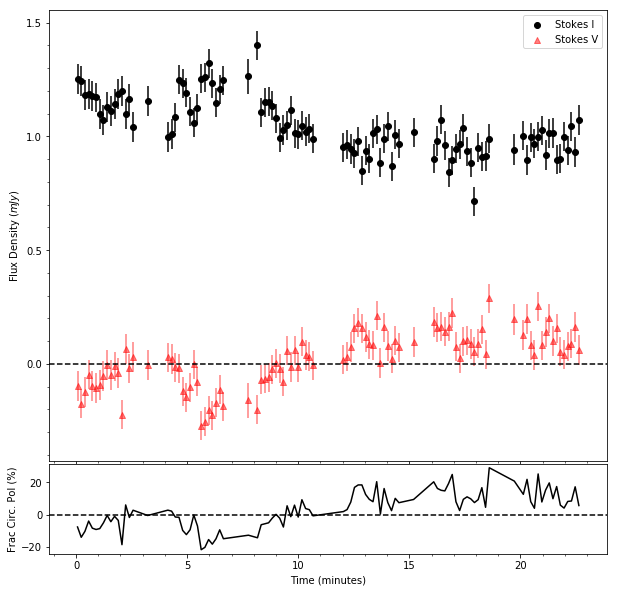

In [12]:
fig,ax = plt.subplots(figsize=(10,10),nrows=2,ncols=1,sharex=True,gridspec_kw = {'hspace':.01,'height_ratios':[5,1]})
ax[0].scatter(time,stI,color='black',marker='o',label='Stokes I')
ax[0].errorbar(time,stI,yerr=stErr,color='k',linestyle='None',label='_nolegend_')
ax[0].scatter(time,stV,color='red',marker='^',label='Stokes V',alpha=0.5)
ax[0].errorbar(time,stV,yerr=stErr,color='red',linestyle='None',label='_nolegend_',alpha=0.5)
ax[0].axhline(y=0,color='k',linestyle='dashed')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].locator_params(axis='y',nbins=4)
ax[0].minorticks_on()

ax[1].plot(time,100*frac,color='k')
ax[1].axhline(y=0,color='k',linestyle='dashed')
ax[1].set_ylabel('Frac Circ. Pol (%)')

plt.xlabel('Time (minutes)')
plt.show()